In [1]:
%matplotlib inline

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import os

import pylab as plt
import numpy as np
import numexpr as ne
import cv2
import time
import astra
import tomopy
import requests, json

In [3]:
plt.viridis();

In [4]:
import tomotools
reload(tomotools)

<module 'tomotools' from 'tomotools.pyc'>

In [5]:
# file_id = 'a789cd0f-f718-4ff2-9f89-01b015cd13c8'
# file_id = '8eee41d5-8c4e-49d8-a496-898200bed0d5'
# file_id = '5e233c53-2925-4774-b680-0d71f73eb8e1'
# file_id = 'f3e80ec9-324f-41bb-a93e-605bcbbcde98'
# file_id = '1032b444-3eeb-4b30-90c6-64f571dc25de'
# file_id = '7efa3f65-ec22-4981-a0dd-40797b15db69'
# file_id = 'e6fe4ea1-79ef-47bc-bc06-d1d62c4fa03d'
# file_id = 'c69910c3-df64-4957-9d06-b1655957e174'  # hand_113_17_40
# file_id = '294e75e0-b24c-4c22-8bfa-79fb9d98bcfa'  # hand_113_15_40
# file_id = 'b564953e-302e-43c5-96cd-3172f8ab94b2'
# file_id = '6953bebf-4c50-4da1-8fa5-a6987a6ca36c'
# experiment_id = '6cdba5b0-f172-4d12-bd21-ea4352109583' #ckp_kuzina_25_20
# experiment_id = 'faa784f4-f653-4765-9dd2-abbf732e2dce' #ckp_bulygina_25_20
# experiment_id = '80f547c3-8761-4f7c-902b-7a9b2e51955b' #ckp_fedulova_17_20
# experiment_id = '32518375-b859-4e95-9a0f-b8ebf8724527' # ckp_kuzina_25_20 _new

# experiment_id = '45b60f9b-0af2-400f-9d48-edc772c22214' #  stone_1_40_25
# experiment_id = '2e5800e3-b4a6-4454-b46f-3e2067ed6559'  # kuzina_mono_mo_40_35
# experiment_id = '7ed638fb-7779-4c3d-b369-27b648c63f29'  # fedulova_mono_mo_40_35
# experiment_id = 'e2d17231-4ae1-4711-8ce7-363a07a159d4'  #bulygina_mono_mo_40_35
# experiment_id = '1a58662a-003c-47e4-a90e-ad9ab525761a' # hand_3_16_17_20
# experiment_id = '90edc8fa-011b-4636-8062-3ecb53fbd170' # zub_pb
# experiment_id = 'b3f10323-71b0-4453-8742-8a981b08ae08' # zub_clear
experiment_id = 'e8271735-dcc4-45bd-b895-8ab9f4b07db9' # mouse bones
data_dir = '/diskmnt/fast/makov/robotom/'

tmp_dir = os.path.join(data_dir, experiment_id)
tomotools.mkdir_p(tmp_dir)
data_file = tomotools.get_experiment_hdf5(experiment_id, data_dir)


INFO:root:Output experiment HDF5 file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9.h5
INFO:root:File exests. Use local copy


In [6]:
#move it in statistisc
# import h5py
# import json
# from pprint import pprint
# with h5py.File(data_file,'a') as h5f:
#     for k,v in h5f['empty'].iteritems():
#         print(k)
#         if int(k) < 400:
#             del h5f['empty'][k]
#     for k,v in h5f['dark'].iteritems():
#         print(k)
#         if int(k) < 400:
#             del h5f['dark'][k]
#     for k,v in h5f['data'].iteritems():
#         if int(k)<19:
#             print(k)
#             pprint(json.loads(v.attrs.items()[0][1])[0]['frame']['object']['angle position'])
#             del h5f['data'][k]

In [7]:
# tomotools.show_statistics(data_file)

In [8]:
empty_images, empty_angles = tomotools.get_frame_group(data_file, 'empty', tmp_dir)

# ea = np.min(empty_angles)
# print np.sum(empty_angles==ea)
dark_images, dark_angles = tomotools.get_frame_group(data_file, 'dark', tmp_dir)
# da = np.min(dark_angles)
# print np.sum(dark_angles==da)
# считаем среднее значение
# empty_image = empty_images.sum(axis=0)/len(empty_images) # empty_images[np.argmin(np.sum(empty_images))] # 
# dark_image = dark_images.sum(axis=0)/len(dark_images) #dark_images.min(axis=0)


empty_image = np.median(empty_images,axis=0) 
dark_image = np.median(dark_images,axis=0)

# dark_image = cv2.medianBlur(dark_image,3)
# empty_image = cv2.medianBlur(empty_image,3)

empty_beam = empty_image - dark_image


mask = empty_beam > 0.01

# Загружаем кадры с даннымии
#TODO: добавить поддержку, когда много кадров на одном угле
data_images, data_angles = tomotools.get_frame_group(data_file, 'data', tmp_dir)

data_images_clear, _  = tomotools.load_create_mm(os.path.join(tmp_dir,'data_images_clear.tmp'),
                        shape=data_images.shape,dtype='float32')

ne.evaluate('data_images - dark_image', out = data_images_clear);
# ne.evaluate('data_images', out = data_images_clear);

# #TODO: Fix it hack

# data_indexes = (data_angles-data_angles.min())<181
# data_images_180, _  = tomotools.load_create_mm(os.path.join(tmp_dir,'data_images_180.tmp'),
#                         shape=(data_indexes.sum(),
#                                data_images.shape[1],
#                                data_images.shape[2]),dtype='float32')
            
# data_angles_180, _ = tomotools.load_create_mm(
#                         os.path.join(tmp_dir,'data_angles_180.tmp'),
#                         shape=(data_indexes.sum(),), dtype='float32')

# pos = 0
# for edi, di in enumerate(data_indexes):    
#     if di:
#         data_images_180[pos] = data_images[edi]-dark_image
#         data_angles_180[pos] = data_angles[edi]
#         pos = pos+1

# del data_images
# del empty_images

INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/group_empty.tmp
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/group_empty_angles.tmp


INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/group_dark.tmp
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/group_dark_angles.tmp


INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/group_data.tmp
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/group_data_angles.tmp
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/data_images_clear.tmp


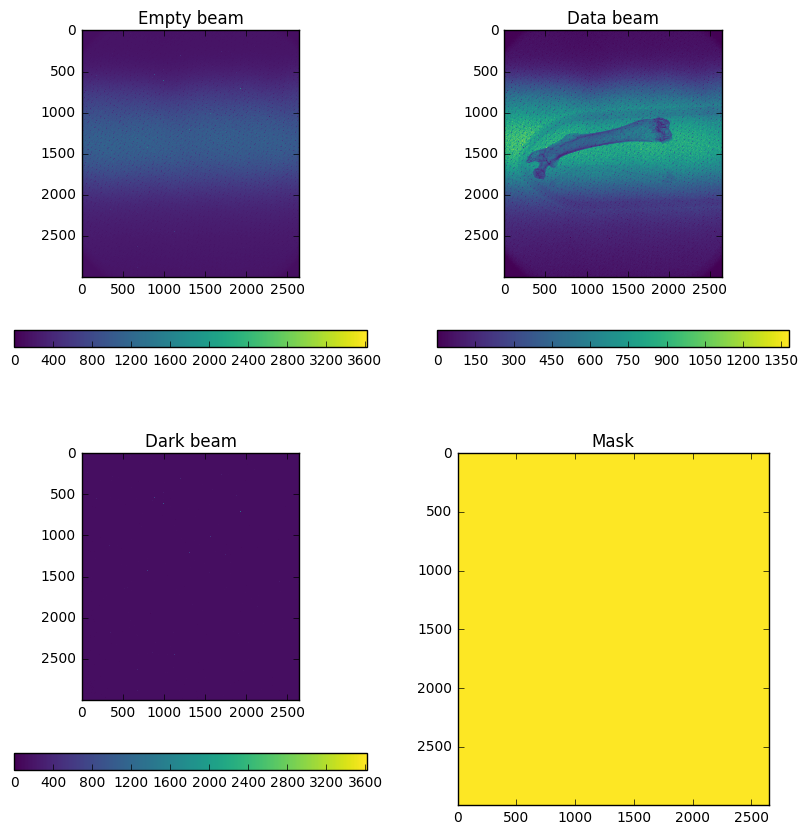

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(empty_image, vmin=0, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.title('Empty beam')

plt.subplot(222)
plt.imshow(data_images_clear[0], vmin=0, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.title('Data beam')


plt.subplot(223)
plt.imshow(dark_image, vmin=0, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.title('Dark beam')


plt.subplot(224)
plt.imshow(mask.astype('int'), interpolation='nearest')
# plt.colorbar(orientation='horizontal')
plt.title('Mask')
#TODO: Check thresshold automaticaly
# plt.plot([sum(empty_beam > i) for i in np.arange(100)])

In [10]:
del data_images
# del data_angles
del empty_image
del empty_images
del dark_images
del dark_image


In [41]:
# data_std = np.std(data_images_clear,axis=0)
data_std = cv2.medianBlur(data_std,3)
# data_mean = np.mean(data_images_clear,axis=0)
data_mean = cv2.medianBlur(data_mean,3)
d = cv2.medianBlur(data_std,3)/cv2.medianBlur(data_mean,3)
thrh = np.percentile(d,50)

In [39]:
d = cv2.medianBlur(data_std,3)/cv2.medianBlur(data_mean,3)
thrh = np.percentile(d,50)

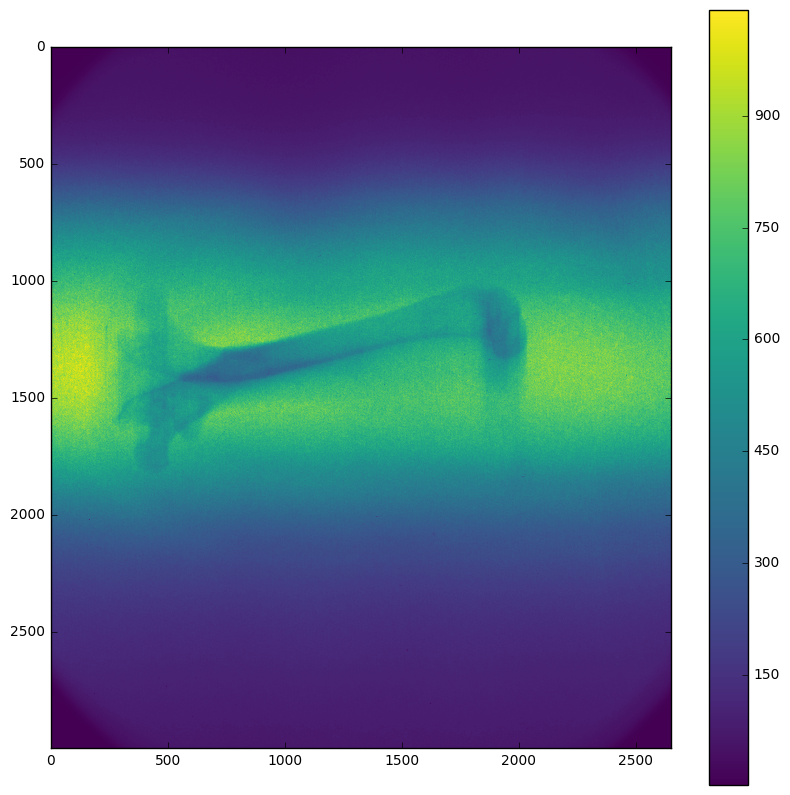

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(data_mean, interpolation='nearest')
plt.colorbar()

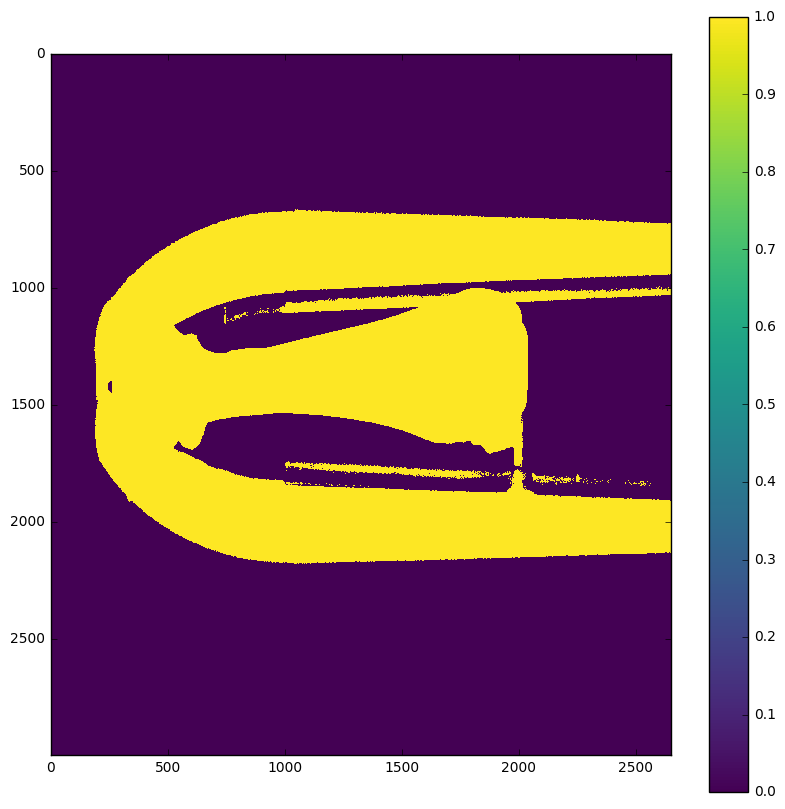

In [95]:
mask = np.ones_like(data_mean)
mask -= data_mean < np.percentile(data_mean, 30)
mask *= 1-(data_std/data_mean < np.percentile(data_std/data_mean, 50))
plt.figure(figsize=(10,10))
plt.imshow(mask, interpolation='nearest')
plt.colorbar()

In [12]:
def crop_mask(mask, up, bottom, left, right):
    threshold = 100
    mask_x_profile = mask.sum(axis=1)
    mask_x_min = np.argwhere(mask_x_profile>threshold).min()+up # up border
    mask_x_max = np.argwhere(mask_x_profile>threshold).max()-bottom # bottom border

    mask_y_profile = mask.sum(axis=0)
    mask_y_min = np.argwhere(mask_y_profile>threshold).min()+left # left border
    mask_y_max = np.argwhere(mask_y_profile>threshold).max()-right # right border
    return  mask_x_min, mask_x_max, mask_y_min, mask_y_max

INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/data_images_masked.tmp
INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/empty_images_masked.tmp


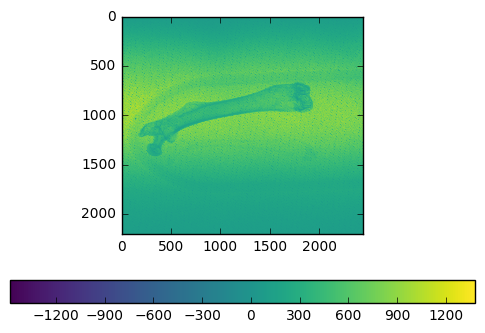

In [13]:
mask_x_min, mask_x_max, mask_y_min, mask_y_max = crop_mask(mask, 400, 400, 100, 100)

mask_new = np.copy(mask[mask_x_min:mask_x_max,mask_y_min:mask_y_max])
# empty_beam = empty_beam[mask_x_min:mask_x_max,mask_y_min:mask_y_max]
## FIX IT
# data_images_croped = data_images_croped[:, mask_x_min:mask_x_max,mask_y_min:mask_y_max]

data_images_masked, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'data_images_masked.tmp'),
                                   shape = (data_angles.shape[0],
                                           mask_new.shape[0], mask_new.shape[1]), dtype='float32',
                                   force_create=True)

empty_masked, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'empty_images_masked.tmp'),
                                   shape = (mask_new.shape[0], mask_new.shape[1]), dtype='float32',
                                   force_create=True)

empty_masked[:] = empty_beam[mask_x_min:mask_x_max,mask_y_min:mask_y_max]


plt.figure()
plt.imshow(data_images_clear[0, mask_x_min:mask_x_max,mask_y_min:mask_y_max], interpolation='nearest')
plt.colorbar(orientation='horizontal')

for di in range(data_images_masked.shape[0]):
    data_images_masked[di] = data_images_clear[di, mask_x_min:mask_x_max,mask_y_min:mask_y_max]
#     data_images_masked[di] = cv2.medianBlur(data_images_masked[di],3)

In [14]:
# plt.figure(figsize=(10,10))
# plt.imshow(data_images_masked[:,:,501]/empty_masked[:,501], cmap=plt.cm.viridis, interpolation='nearest')
# plt.axis('tight')
# plt.colorbar(orientation='horizontal')

In [15]:
del empty_beam
del data_images_clear

In [16]:
def group_data(data_images,data_angles,  mmap_file_dir):
    uniq_angles,_ = tomotools.load_create_mm(
        os.path.join(mmap_file_dir,'uniq_angles.tmp'),
        shape=(len(list(set(data_angles))),),
        dtype='float32',force_create=True)
    uniq_angles[:] = list(set(data_angles))
    
    uniq_data_images,_ = tomotools.load_create_mm(
        os.path.join(mmap_file_dir,'uniq_data_images.tmp'),
        shape=(len(uniq_angles), data_images.shape[1], data_images.shape[2]),
        dtype='float32',force_create=True)

    for ua_id, ua in enumerate(uniq_angles):
        indexes = np.argwhere(data_angles==uniq_angles[ua_id])
        if len(indexes)>1:
            tmp_images = data_images[indexes]
            tmp_images = np.squeeze(tmp_images)
            mean_image = np.mean(tmp_images, axis=0)
            uniq_data_images[ua_id] = mean_image
        else:
            uniq_data_images[ua_id]=data_images[indexes]
    return uniq_data_images, uniq_angles

uniq_data_images, uniq_angles = group_data(data_images_masked, data_angles, tmp_dir)
del data_images_masked, data_angles

INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/uniq_angles.tmp
INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/uniq_data_images.tmp


In [17]:
#normalize data frames and calculate sinograms
# empty_masked[empty_masked <= 0] = 1e-9

for di in range(uniq_data_images.shape[0]):
    t = uniq_data_images[di]
    t=t/empty_masked
    t[t<1e-8] = 1e-8
    t[t>1] = 1
    uniq_data_images[di] = cv2.medianBlur(t,3)
    t[t<1e-8] = 1e-8
    t[t>1] = 1

del empty_masked

In [18]:
sinogram, _ = tomotools.load_create_mm(os.path.join(tmp_dir, 'sinogram.tmp'), shape=uniq_data_images.shape,
                         dtype='float32') 
ne.evaluate('-log(uniq_data_images)', out=sinogram);

INFO:root:Loading existing file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/sinogram.tmp


In [19]:
# plt.figure(figsize=(7,5))
# plt.imshow(uniq_data_images[np.argsort(uniq_angles),:,int(sinogram.shape[-1]/1.75)])
# plt.axis('tight')
# # plt.colorbar()

In [20]:
del uniq_data_images

In [21]:
# # build frames for video
# images_dir = os.path.join(tmp_dir,'images')
# tomotools.mkdir_p(images_dir)
# im_max=np.max(sinogram)
# im_min=np.min(sinogram)
# print(im_min, im_max)
# for ia, a in tomotools.log_progress(list(enumerate(np.argsort(uniq_angles)))):
# #     print('{:34}'.format(ia))
#     plt.imsave(os.path.join(images_dir,'prj_{:03}.png'.format(ia)),
#                np.rot90(sinogram[a],3), vmin=im_min, vmax=im_max,
#                cmap=plt.cm.gray_r)

In [22]:
# !cd {images_dir} && avconv -r 10 -i "prj_%03d.png" -b:v 1000k prj.avi

In [23]:
# !cd {images_dir} && rm prj.mp4

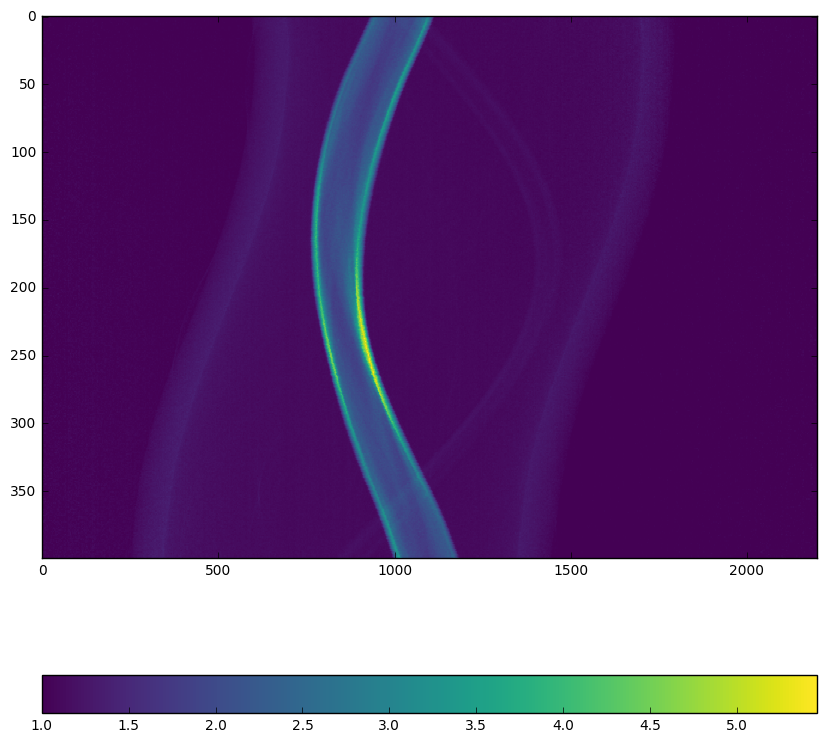

In [24]:
tmp_sinogram = sinogram[np.argsort(uniq_angles),:,int(sinogram.shape[-1]//2)+3]

plt.figure(figsize=(10,10))
plt.imshow(np.exp(tmp_sinogram), cmap=plt.cm.viridis, interpolation='nearest')
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [25]:
import scipy.ndimage
def my_rc(sino0, level):
    def get_my_b(level):
        t= np.mean(sino0, axis=0)
        gt = scipy.ndimage.filters.gaussian_filter1d(t,level/2.)
        return gt-t
    
    def get_my_a(level):
        my_b = get_my_b(level)
        return np.mean(my_b)/my_b.shape[0]
    
    my_a = get_my_a(level)
    my_b = get_my_b(level)
    
    res = sino0.copy()
    if not level==0:
        res+= sino0*my_a+my_b
    
    return res

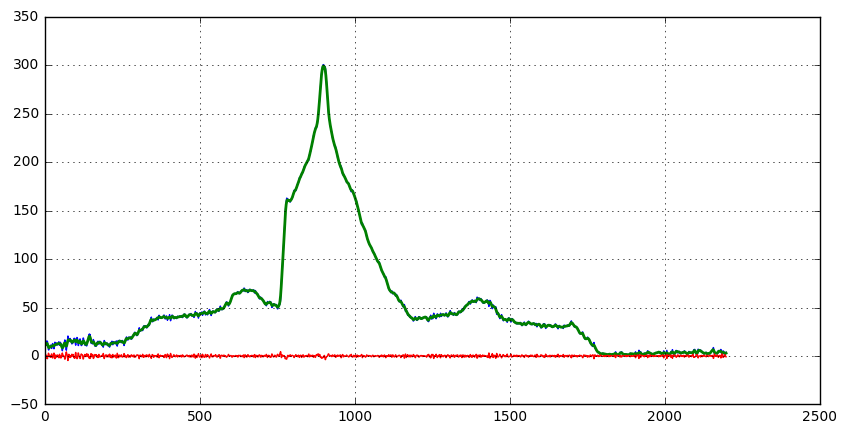

In [26]:
rc_level = 5
plt.figure(figsize=(10,5))
plt.plot(tmp_sinogram.sum(axis=0))
plt.plot(my_rc(tmp_sinogram,rc_level).sum(axis=0), lw=2)
plt.plot(my_rc(tmp_sinogram,rc_level).sum(axis=0)-tmp_sinogram.sum(axis=0))
plt.grid()

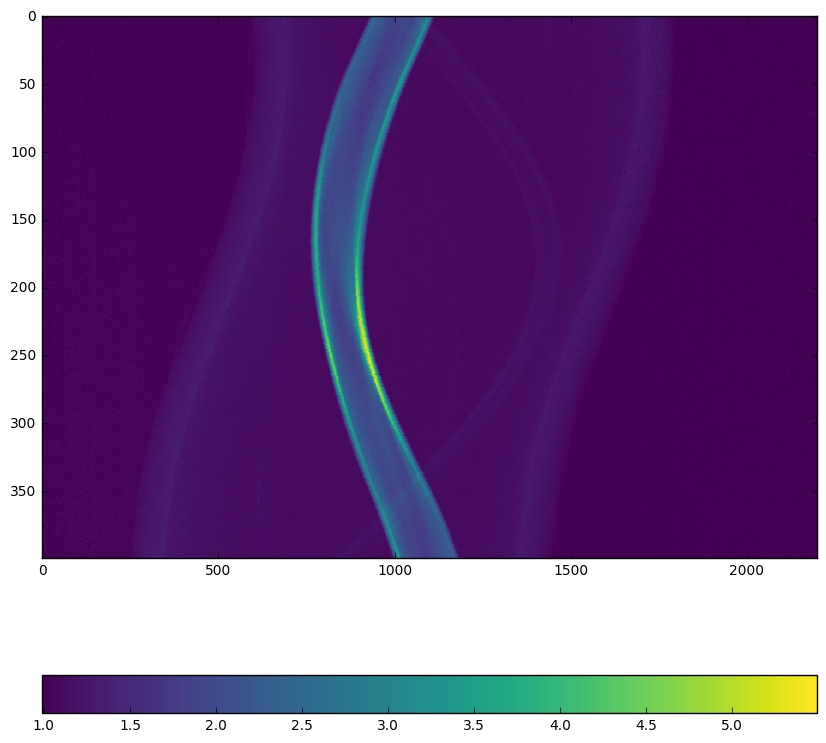

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(np.exp(my_rc(tmp_sinogram, rc_level)), cmap=plt.cm.viridis, interpolation='nearest')
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [28]:
for s in tomotools.log_progress(range(sinogram.shape[1])):
    sinogram[:,s,:] = my_rc(sinogram[:,s,:],5)

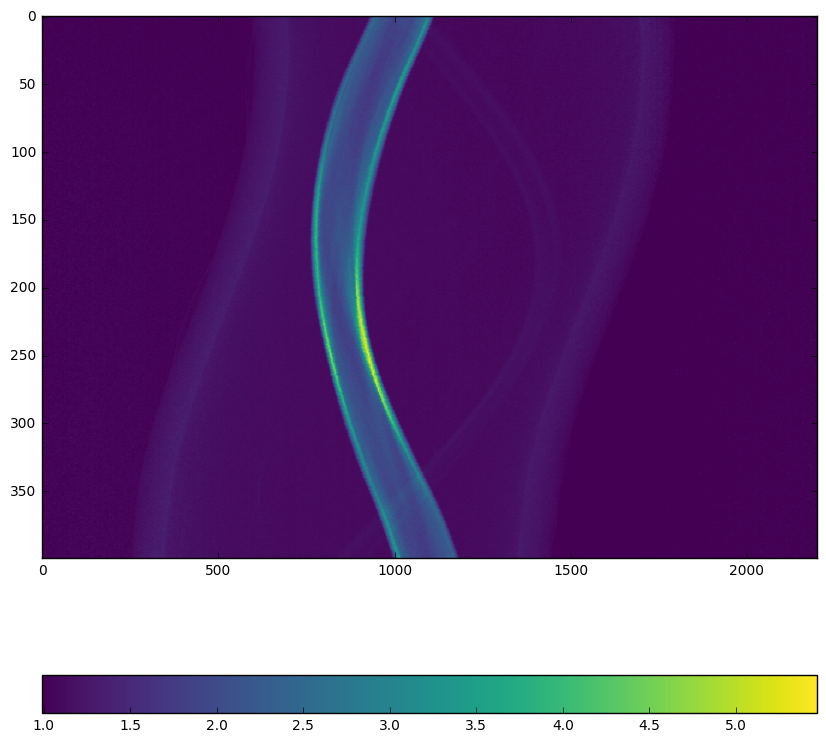

In [29]:
tmp_sinogram = sinogram[np.argsort(uniq_angles),:,int(sinogram.shape[-1]//2)+3]

plt.figure(figsize=(10,10))
plt.imshow(np.exp(tmp_sinogram), cmap=plt.cm.viridis, interpolation='nearest')
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [35]:
# seraching detector rotation angle
for zero_angle in uniq_angles:
#     zero_angle = np.min(uniq_angles)
    position_0 = np.argwhere(np.isclose(uniq_angles, zero_angle, atol=0.05))[0][0]
    position_180 = np.argwhere(np.isclose(uniq_angles, 180+zero_angle, atol=0.05))
    if len(position_180)>0:
        position_180=position_180[0][0]
        print uniq_angles[position_0], position_0
        print uniq_angles[position_180], position_180
        break

def cv_rotate(x, angle):
    """
    Rotate square array using OpenCV2 around center of the array
    :param x: 2d numpy array
    :param angle: angle in degrees
    :return: rotated array
    """
    x_center = tuple(
        np.array((x.shape[1], x.shape[0]), dtype='float32') / 2.0 - 0.5)
    rot_mat = cv2.getRotationMatrix2D(x_center, angle, 1.0)
    xro = cv2.warpAffine(
        x, rot_mat, (x.shape[1], x.shape[0]), flags=cv2.INTER_LINEAR)
    return xro


data_0_orig = np.rot90(sinogram[position_0]).copy()
data_180_orig = np.rot90(sinogram[position_180]).copy()

90.0 21
270.0 313


In [31]:
# np.save('data_0.npy', data_0)
# np.save('data_180.npy', data_180)

In [37]:
def grad(x):
    return np.sqrt((np.diff(x, axis=0)**2)[:,:-1]+(np.diff(x, axis=1)**2)[:-1,:])

data_0 = cv2.medianBlur(data_0_orig,5)
data_180 = cv2.medianBlur(data_180_orig,5)

data_0 = grad(data_0)
data_180 = grad(data_180)

In [38]:
from scipy.optimize import minimize
def f(x):
    alfa= x[0]
    shift = int(x[1])
    if shift >= 0:
        t = enp.fliplr(cv_rotate(data_180[:,shift:],alfa))-cv_rotate(data_0[:,shift:],alfa)
    else:
        t = np.fliplr(cv_rotate(data_180[:,:shift],alfa))-cv_rotate(data_0[:,shift],alfa)
        
    res = np.sum(t*t)/np.prod(t.shape)
    return res

def corr(x):
    alfa= x[0]*10.
    shift_x = int(x[1])
    if shift_x >= 0:
        t_180 = data_180[:,shift_x:]
        t_0 = data_0[:,shift_x:]
    else:
        t_180 = data_180[:,:shift_x]
        t_0 = data_0[:,:shift_x]
        
    shift_y = int(x[2])//10
    if shift_y > 0:
        t_180 = t_180[shift_y:,:]
        t_0 = t_0[:-shift_y,:]
    elif shift_y < 0:
        t_180 = t_180[:shift_y,:]
        t_0 = t_0[-shift_y:,:]
    
    
#     t_mask = np.zeros_like(t_0)
#     shape_min = np.min(t_mask.shape)
#     r_mask = shape_min//2
#     X,Y = np.meshgrid(np.arange(t_mask.shape[1])-t_mask.shape[1]//2,
#                       np.arange(t_mask.shape[0])-t_mask.shape[0]//2)
#     t_mask = X**2+Y**2<r_mask**2    
    
    tt_180 = np.fliplr(cv_rotate(t_180,alfa))
    tt_180 = cv2.medianBlur(tt_180,5) #*t_mask
    tt_0 = cv_rotate(t_0,alfa)
    tt_0 = cv2.medianBlur(tt_0,5) #*t_mask
#     res = -np.correlate(tt_0.flat,tt_180.flat)
    res = np.sum((tt_0-tt_180)**2)

    return res

x0 = [0.1,-355,30]
res= minimize(corr, x0, method='Nelder-Mead')
print res

 final_simplex: (array([[ -3.83850851e-04,  -1.45591348e+02,   5.78744662e+01],
       [ -3.83846817e-04,  -1.45591363e+02,   5.78744562e+01],
       [ -3.83847087e-04,  -1.45591294e+02,   5.78744906e+01],
       [ -3.83845250e-04,  -1.45591338e+02,   5.78744708e+01]]), array([ 95.53426361,  95.53426361,  95.53426361,  95.53426361]))
           fun: 95.534263610839844
       message: 'Optimization terminated successfully.'
          nfev: 192
           nit: 91
        status: 0
       success: True
             x: array([ -3.83850851e-04,  -1.45591348e+02,   5.78744662e+01])


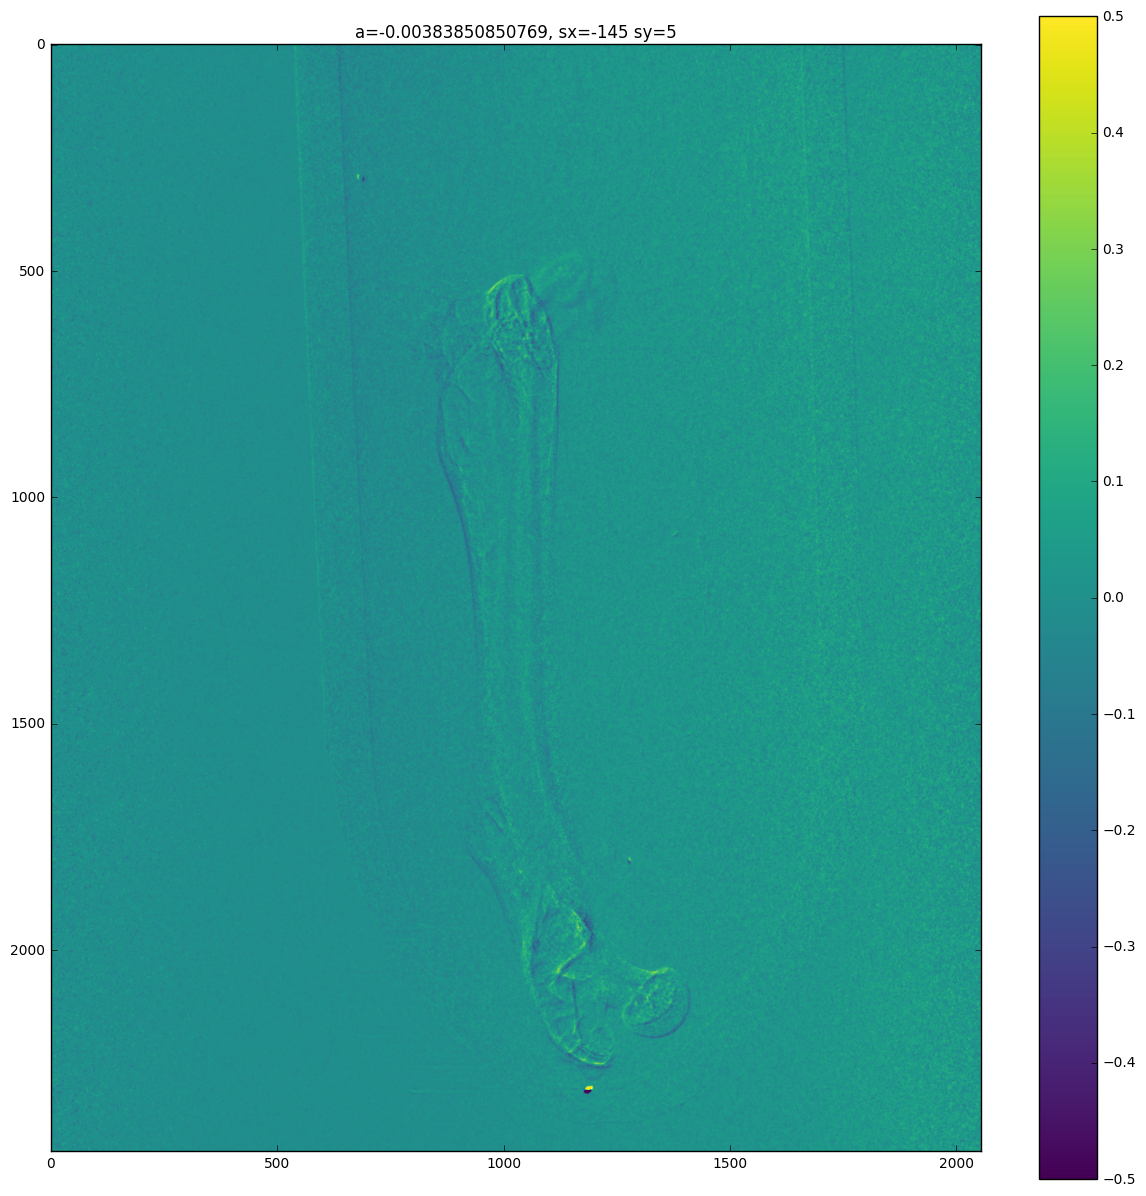

In [43]:
alfa, shift_x, shift_y = res.x[0]*10., int(res.x[1]), int(res.x[2])//10

if shift_x >= 0:
    t_180 = data_180_orig[:,shift_x:]
    t_0 = data_0_orig[:,shift_x:]
else:
    t_180 = data_180_orig[:,:shift_x]
    t_0 = data_0_orig[:,:shift_x]

if shift_y > 0:
    t_180 = t_180[shift_y:,:]
    t_0 = t_0[:-shift_y,:]
elif shift_y < 0:
    t_180 = t_180[:shift_y,:]
    t_0 = t_0[-shift_y:,:]
    
    
tt_180 = np.fliplr(cv_rotate(t_180,alfa))
tt_0 = cv_rotate(t_0,alfa)
    
plt.figure(figsize=(15,15))
plt.imshow(tt_180-tt_0, cmap=plt.cm.viridis, vmin=-0.5, vmax=0.5)
plt.title('a={}, sx={} sy={}'.format(alfa,shift_x, shift_y))
plt.colorbar()
plt.show()

In [39]:
# from scipy.optimize import minimize
# def f(x):
#     alfa= x[0]
#     shift = int(x[1])
#     if shift >= 0:
#         t = enp.fliplr(cv_rotate(data_180[:,shift:],alfa))-cv_rotate(data_0[:,shift:],alfa)
#     else:
#         t = np.fliplr(cv_rotate(data_180[:,:shift],alfa))-cv_rotate(data_0[:,shift],alfa)
        
#     res = np.sum(t*t)/np.prod(t.shape)
#     return res

# def corr(x):
#     alfa= x[0]*10.
#     shift = int(x[1])
#     if shift >= 0:
#         t_180 = data_180[:,shift:]
#         t_0 = data_0[:,shift:]
#     else:
#         t_180 = data_180[:,:shift]
#         t_0 = data_0[:,:shift]
    
    
# #     t_mask = np.zeros_like(t_0)
# #     shape_min = np.min(t_mask.shape)
# #     r_mask = shape_min//2
# #     X,Y = np.meshgrid(np.arange(t_mask.shape[1])-t_mask.shape[1]//2,
# #                       np.arange(t_mask.shape[0])-t_mask.shape[0]//2)
# #     t_mask = X**2+Y**2<r_mask**2    
    
#     tt_180 = np.fliplr(cv_rotate(t_180,alfa))
#     tt_180 = cv2.medianBlur(tt_180,5) #*t_mask
#     tt_0 = cv_rotate(t_0,alfa)
#     tt_0 = cv2.medianBlur(tt_0,5) #*t_mask
#     res = -np.correlate(tt_0.flat,tt_180.flat)
# #     TODO: add mask support 
# #     res = -np.sum(tt_0*tt_180)/np.sqrt(np.sum(tt_0**2)*np.sum(tt_180**2))*np.prod(tt_0.shape) #*np.prod(t_mask.shape)
#     return res

# x0 = [0.1,-355]
# res= minimize(corr, x0, method='Nelder-Mead')
# print res

In [40]:
# alfa, shift = res.x[0]*10., int(res.x[1])

# if shift >= 0:
#     t_180 = data_180[:,shift:]
#     t_0 = data_0[:,shift:]
# else:
#     t_180 = data_180[:,:shift]
#     t_0 = data_0[:,:shift]
    
# tt_180 = np.fliplr(cv_rotate(t_180,alfa))
# tt_0 = cv_rotate(t_0,alfa)
    
# plt.figure(figsize=(15,15))
# plt.imshow(tt_180-tt_0, cmap=plt.cm.viridis, vmin=-0.5, vmax=0.5)
# plt.title('a={}, s={}'.format(alfa,shift))
# plt.colorbar()
# plt.show()


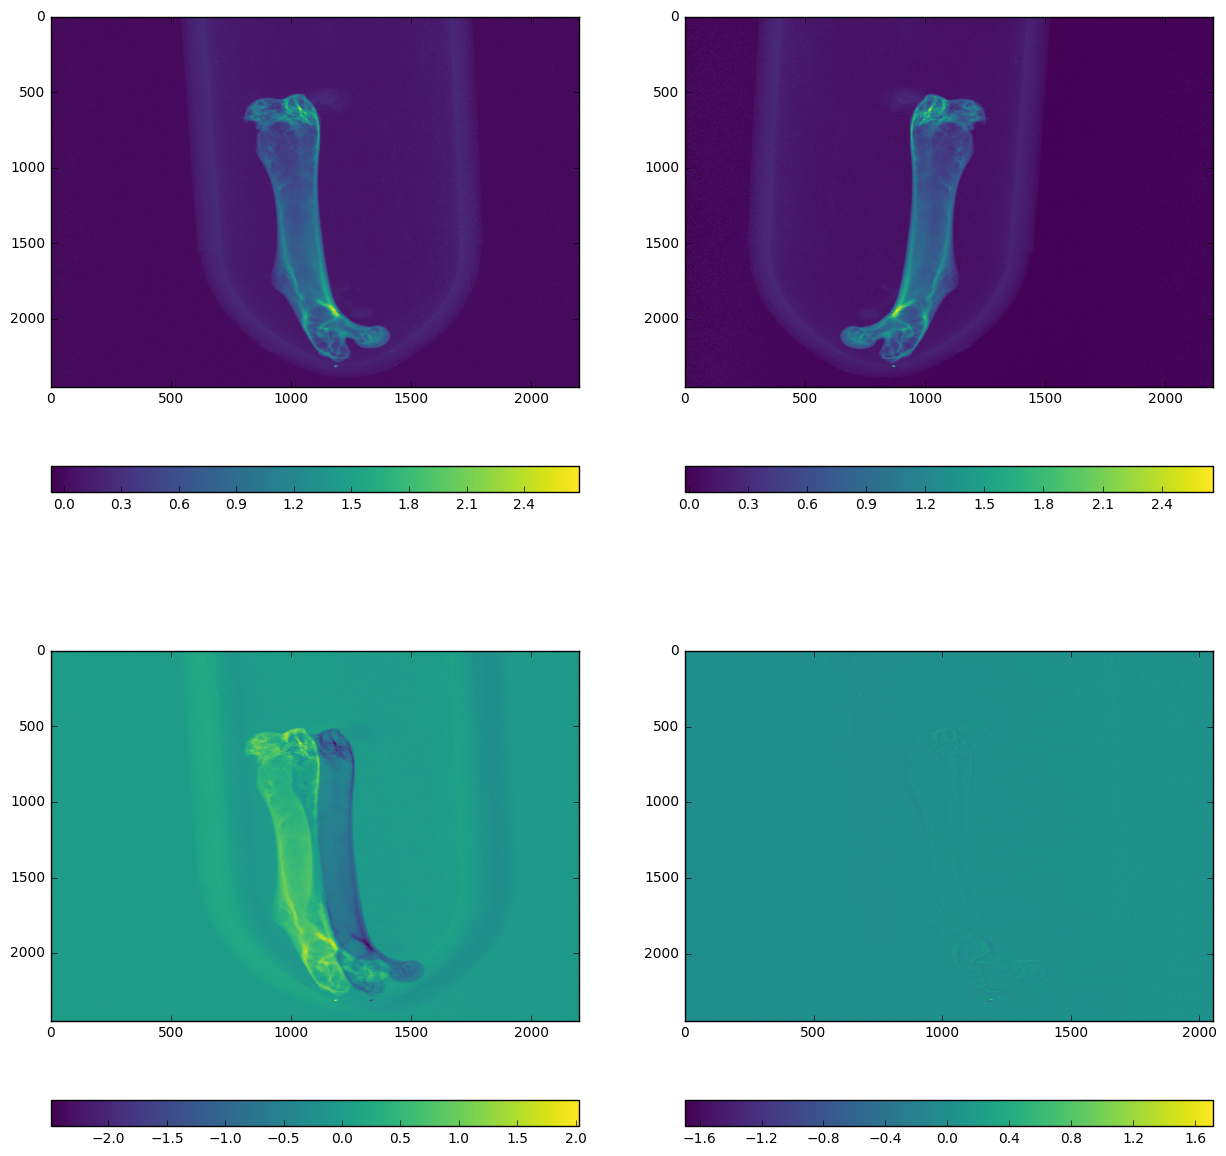

In [44]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(data_0_orig,cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(222)
plt.imshow(data_180_orig,cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(223)
plt.imshow(data_0_orig - np.fliplr(data_180_orig),cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(224)
# alfa = 0.1
# shift = -77
plt.imshow(tt_180-tt_0, cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [ ]:
# sinogram_fixed, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'sinogram_fixed.tmp'),
#                                 shape=(sinogram.shape[0], sinogram.shape[1]-abs(shift),sinogram.shape[2]),
#                                 dtype='float32')

# #fix axis tlit
# for i in range(sinogram.shape[0]):
#     if shift >= 0:
#         t = sinogram[i,shift:]
#     else:
#         t = sinogram[i,:shift]
#     t = cv_rotate(t, alfa)
#     sinogram_fixed[i] = t
    
# del sinogram

In [46]:
sinogram.shape

(400, 2199, 2449)

In [97]:
sinogram_fixed, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'sinogram_fixed.tmp'),
                                shape=(sinogram.shape[0], sinogram.shape[1]-abs(shift_x),sinogram.shape[2]),
                                dtype='float32', force_create=True)

#fix axis tlit
for i in range(sinogram.shape[0]):
    t = sinogram[i].copy()
    if shift_x > 0:
        t = t[shift_x:]
    elif shift_x < 0:
        t = t[:shift_x]
    t_angle = uniq_angles[i]
    
    if not shift_y ==0 :
        delta_angle = t_angle - uniq_angles[position_0]+90
        tmp_shift_y = int(np.sin(delta_angle/180.*np.pi)*shift_y)
        t = np.roll(t, -tmp_shift_y, -1)
        t[:,0:np.abs(shift_y)]=0
        t[:,-np.abs(shift_y):]=0
        
    t = cv_rotate(t, alfa)
    sinogram_fixed[i] = t
    
# del sinogram

INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/sinogram_fixed.tmp


In [98]:
s1 = np.require(sinogram_fixed[...,int(sinogram_fixed.shape[-1]/1.5)],
                dtype=np.float32, requirements=['C'])

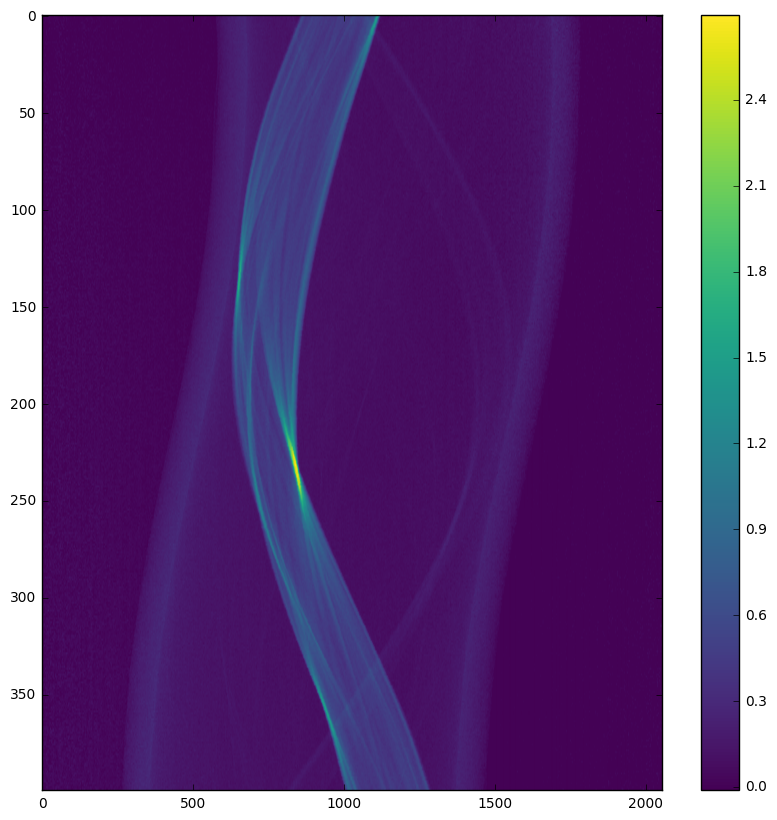

In [99]:
plt.figure(figsize=(10,10))
plt.imshow(sinogram_fixed[np.argsort(uniq_angles),:,int(sinogram_fixed.shape[-1]/1.5)], cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar()
plt.show()

In [ ]:
del sinogram_fixed

In [ ]:
del data_0, data_180 ,tmp_sinogram, uniq_angles

In [ ]:
del mask, t_0, t_180, zero_angle

In [6]:
uniq_angles, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'uniq_angles.tmp'),
                             shape= None,
                             dtype='float32')
s1, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'sinogram_fixed.tmp'),
                                shape= None,
                                dtype='float32')

rec_vol, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'rec.tmp'),
               dtype=np.float32,
               shape = (s1.shape[-1],s1.shape[1],s1.shape[1]))



INFO:root:Loading existing file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/uniq_angles.tmp
INFO:root:Loading existing file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/sinogram_fixed.tmp
INFO:root:Loading existing file: /diskmnt/fast/makov/robotom/e8271735-dcc4-45bd-b895-8ab9f4b07db9/rec.tmp


In [ ]:
# import h5py
# with h5py.File('zub_clear.h5','w') as h5f:
#     h5f.create_dataset('sinogram',dtype='float32',
#                        data = s1[np.argsort(uniq_angles),...], 
#                        compression="gzip", compression_opts=1)

In [ ]:
# import h5py
# with h5py.File('zub_pb.h5') as h5f:
#     sino = h5f['sinogram'][:,:,500]

# plt.figure(figsize=(10,10))
# plt.imshow(sino, cmap=plt.cm.viridis)
# plt.colorbar(orientation='horizontal')
# plt.axis('tight')
# plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(s1[np.argsort(uniq_angles),:,int(s1.shape[-1]/1.75)], cmap=plt.cm.viridis)
# plt.colorbar(orientation='horizontal')
# plt.axis('tight')
# plt.show()

In [7]:
def astra_tomo2d_parallel(sinogram, angles):
    astra.astra.set_gpu_index([1,])
    angles = angles.astype('float64')
    detector_size = sinogram.shape[1]
    

    rec_size = detector_size
    vol_geom = astra.create_vol_geom(rec_size, rec_size)
    proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)


    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
#     proj_id = astra.create_projector('strip', proj_geom, vol_geom) # for CPU reconstruction only
    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}
    
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 1)
    
    cfg = astra.astra_dict('CGLS_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}

    alg_id = astra.algorithm.create(cfg)
    
    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 10)
    
    # Get the result
    rec = astra.data2d.get(rec_id)
    
    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec

def astra_tomo3d_parallel(sinogram, angles, rec_vol, slice_start, slice_stop):
    astra.astra.set_gpu_index([1,])
    angles = angles.astype('float64')
    detector_size = sinogram.shape[1]
#         slices_number = sinogram.shape[0]
    slices_number = slice_stop - slice_start
        
    rec_size = detector_size
    vol_geom = astra.create_vol_geom(rec_size, rec_size, slices_number)
    proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0,  slices_number, detector_size, angles)


    sinogram_id = astra.data3d.create('-sino', proj_geom, np.rollaxis(sinogram,-1)[slice_start:slice_stop])
    # Create a data object for the reconstruction
#     rec_id = astra.data3d.link('-vol', vol_geom, rec_vol[slice_start:slice_stop])
    rec_id = astra.data3d.create('-vol', vol_geom)
    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('CGLS3D_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}
    #cfg['option']['MinConstraint'] = 0
    cfg['option']['MinConstraint'] = -0.01

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)
#     astra.data3d.info()
    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 30)
    
    # Get the result
    rec = astra.data3d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(rec_id)
    astra.data3d.delete(sinogram_id)
    astra.clear()
    return rec

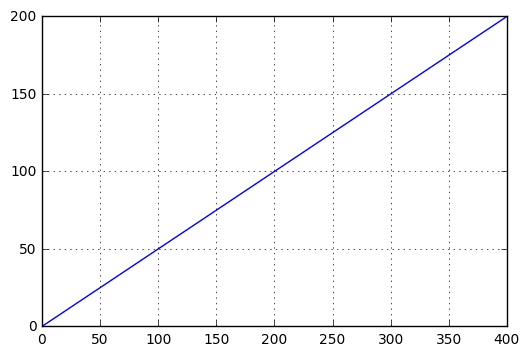

In [8]:
plt.plot(sorted(uniq_angles)-uniq_angles.min())
plt.grid()
plt.show()

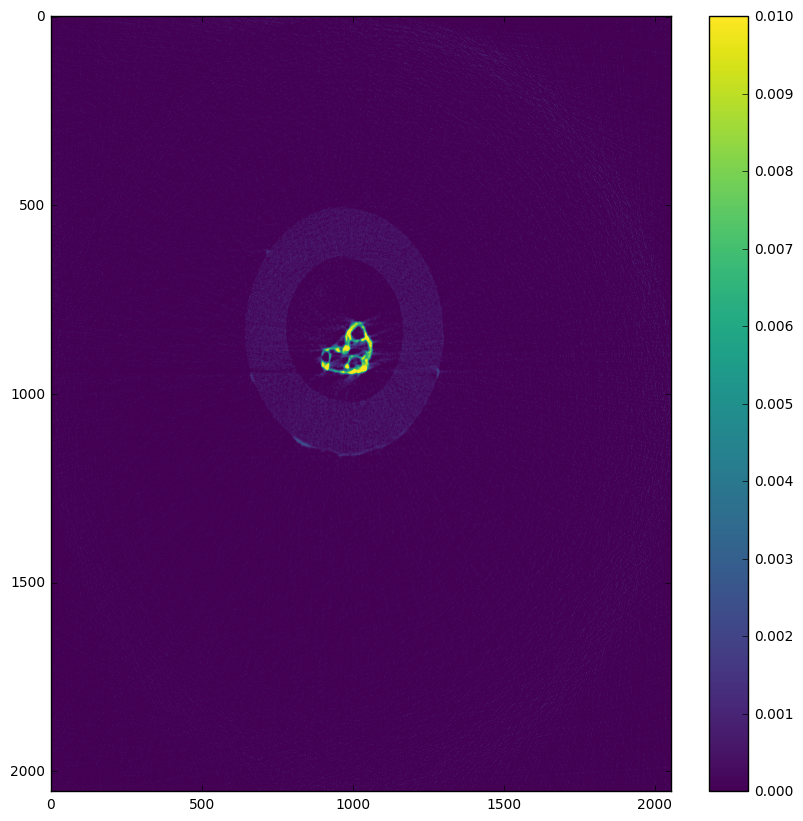

In [9]:
# %%timeit
#preview
sss = s1[...,int(s1.shape[-1]*0.1)]
t_angles = (uniq_angles-uniq_angles.min())<=180 # remove angles >180
rec_slice = astra_tomo2d_parallel(sss[t_angles], uniq_angles[t_angles]*np.pi/180)

plt.figure(figsize=(10,10))
plt.imshow(rec_slice, vmin=0, vmax=0.01)
plt.axis('tight')
plt.colorbar()
plt.show()

In [ ]:
# t = time.time()
# angles =np.array(uniq_angles)*np.pi/180
# t_rec_vol = astra_tomo2d_parallel(s1[...,600], angles)
# print(time.time()-t)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(t_rec_vol, vmin=0)
# plt.axis('tight')
# plt.colorbar()
# plt.show()

In [ ]:
# #3d case
# t = time.time()
# print s1.shape
# step = 50
# angles =np.array(uniq_angles)*np.pi/180
# # for i in log_progress(range(1500, 1700, step)):
# for i in tomotools.log_progress(range(0, s1.shape[-1], step)):
#     slice_start= i 
#     slice_stop= min(i+step, s1.shape[-1])
#     rec_vol[slice_start:slice_stop] = astra_tomo3d_parallel(s1, angles,
#                                        slice_start=slice_start, slice_stop=slice_stop
#                                   )
# print(time.time()-t)

In [ ]:
#multi 2d case
t = time.time()
print s1.shape
t_angles = (uniq_angles-uniq_angles.min())<=180  # remove angles >180
angles =np.array(uniq_angles)*np.pi/180
# for i in log_progress(range(1500, 1700, step)):
for i in tomotools.log_progress(range(0, s1.shape[-1])):
    sino = s1[t_angles,:,i]
    rec_vol[i] = astra_tomo2d_parallel(sino, angles[t_angles])
print(time.time()-t)

(400, 2054, 2449)


Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(rec_vol[int(rec_vol.shape[0]/2)], cmap=plt.cm.viridis, vmin=0)
plt.axis('tight')
plt.colorbar()
plt.show()

In [ ]:
rec_vol_filtered, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'rec_filtered.tmp'),
               dtype=np.float32,
               shape = rec_vol.shape)

In [ ]:
t = time.time()
print rec_vol.shape
step = 200
angles =np.array(uniq_angles)*np.pi/180
# for i in log_progress(range(1500, 1700, step)):
for i in tomotools.log_progress(range(0, rec_vol.shape[0], step)):
    slice_start= i 
    slice_stop= min(i+step, s1.shape[-1])
    rec_vol_filtered[slice_start:slice_stop] = tomopy.remove_ring(
        rec_vol[slice_start:slice_stop],
        thresh=0.0005,  theta_min=90, rwidth=10)
print(time.time()-t)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(rec_vol_filtered[int(rec_vol_filtered.shape[0]/2)], cmap=plt.cm.viridis, vmin=0)
plt.axis('tight')
plt.colorbar()
plt.show()

In [15]:
def save_amira(in_array, out_path, reshape=3):
    data_path = out_path
    with open(os.path.join(data_path, 'amira.raw'), 'wb') as amira_file:
        in_array[::reshape,::reshape,::reshape].tofile(amira_file)
        file_shape = in_array[::reshape,::reshape,::reshape].shape
        with open(os.path.join(data_path, 'tomo.hx'), 'w') as af:
                af.write('# Amira Script\n')
                af.write('remove -all\n')
                af.write(r'[ load -raw ${SCRIPTDIR}/amira.raw little xfastest float 1 '+
                         str(file_shape[1])+' '+str(file_shape[2])+' '+str(file_shape[0])+
                         ' 0 '+str(file_shape[1]-1)+' 0 '+str(file_shape[2]-1)+' 0 '+str(file_shape[0]-1)+
                         ' ] setLabel tomo.raw\n')


In [16]:
save_amira(rec_vol, tmp_dir)

In [17]:
storage_dir = '/diskmnt/a/makov/'

In [18]:
files_to_remove =  ['data_images_clear.tmp','data_images_masked.tmp',
                    'empty_images_masked.tmp',
                    'uniq_data_images.tmp','sinogram.tmp',
                    'group_empty.tmp','group_empty_angles.tmp',
                    'group_dark.tmp','group_dark_angles.tmp',
                    'group_data.tmp','group_data_angles.tmp']
for fr in files_to_remove:
    try:
        os.remove(os.path.join(tmp_dir,fr))
    except:
        pass
    try:
        os.remove(os.path.join(tmp_dir,fr+'.size'))
    except:
        pass


In [22]:
!cp -r {os.path.join(data_dir, experiment_id)} {os.path.join(storage_dir, experiment_id)}